# PROBLEMA 4: **Clasificación de especies en un hábitat**  

### Entrega: Daniel Rojo Mata

## **Enunciado del problema**  

Un equipo de biólogos está estudiando **dos especies de aves** que habitan en una región montañosa. Estas especies tienen **preferencias distintas** por ciertas condiciones ambientales, lo que influye en su distribución geográfica.  

Para caracterizar los lugares donde han sido observadas, los investigadores registran las siguientes variables:  
- **x1:** Temperatura media del hábitat (°C)  
- **x2:** Altitud relativa del hábitat (m)  
- **y:** Especie  

Descarga el conjunto de datos de especies de aves disponible en [este enlace](http://turing.iimas.unam.mx/~gibranfp/cursos/aprendizaje_automatizado/data/aves.csv) y realiza lo siguiente:  

### **1. Entrenamiento del clasificador:**  
   - Entrena un **clasificador Naive Bayes Gaussiano** utilizando las características ambientales registradas.  

### **2. Evaluación del modelo:**  
   - Evalúa el clasificador en el **conjunto de entrenamiento**, calculando el **porcentaje de aciertos**.  

### **3. Visualización y análisis:**  
   - **Visualiza los datos** mediante gráficos adecuados.  
   - **Muestra la frontera de decisión** del clasificador.  
   - **Calcula y analiza la matriz de confusión** para evaluar el rendimiento del modelo.  
   - Discute los resultados obtenidos y el desempeño del clasificador.  

## **Descripción del conjunto de datos**  
El archivo `aves.csv` contiene observaciones de dos especies de aves registradas en distintos hábitats. Cada fila representa un hábitat específico y está descrita por:  
- **Temperatura media (x1):** Expresada en grados Celsius.  
- **Altitud relativa (x2):** Medida en metros.  
- **Especie (y):** Indica a qué especie pertenece la observación.  


# **Solución**:

### Librerías

In [29]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

## Clasificador Gaussiano

In [2]:
class NaiveBayesGaussiano:
    def __init__(self):
        """
        Inicializa los atributos del modelo de Naive Bayes con distribución Gaussiana.
        """
        self.media = None  # Media de cada característica por clase
        self.desviacion = None  # Desviación estándar de cada característica por clase
        self.proba_clase = None  # Probabilidad a priori de cada clase
        self.clases = None  # Clases únicas en el conjunto de datos
        self.epsilon = 1e-6  # Pequeño valor para evitar divisiones por 0 en la varianza

    def fit(self, X_ent, y_ent):
        """
        Entrena el modelo con el conjunto de entrenamiento.
        Calcula los parámetros de la distribución Gaussiana (media y desviación estándar) 
        para cada característica en cada clase.
        
        Parámetros:
            X_ent: ndarray de forma (num_muestras, num_características), matriz de datos de entrada.
            y_ent: ndarray de forma (num_muestras,), vector de etiquetas de clase.
        """
        self.clases = np.unique(y_ent)  # Obtiene las clases únicas en el conjunto de entrenamiento
        num_clases = len(self.clases)  # Número total de clases
        num_caracteristicas = X_ent.shape[1]  # Número de características en los datos
        
        # Inicializa matrices para almacenar la media, desviación estándar y probabilidades a priori, resp.
        self.media = np.zeros((num_clases, num_caracteristicas))
        self.desviacion = np.zeros((num_clases, num_caracteristicas))
        self.proba_clase = np.zeros(num_clases)
        
        # Itera sobre cada clase para calcular sus parámetros estadísticos
        for i, clase in enumerate(self.clases):
            X_clase = X_ent[y_ent == clase]  # Filtra las muestras que pertenecen a la clase actual
            self.media[i, :] = X_clase.mean(axis=0)  # Calcula la media de cada característica
            self.desviacion[i, :] = np.maximum(X_clase.std(axis=0), self.epsilon)  # Evita sigma = 0
            self.proba_clase[i] = len(X_clase) / len(X_ent)  # Calcula la probabilidad a priori de la clase

    def gaussian_log(self, x, mu, sigma):
        """
        Calcula la densidad de probabilidad de una distribución Gaussiana para cada característica.

        Parámetros:
            x: ndarray de forma (num_muestras, num_características), valores de entrada.
            mu: ndarray de forma (num_características,), media de la distribución Gaussiana.
            sigma: ndarray de forma (num_características,), desviación estándar de la distribución Gaussiana.

        return:
            Log-probabilidad de cada característica bajo la distribución Gaussiana correspondiente.
        """
        sigma = np.maximum(sigma, self.epsilon)  # Asegura que sigma no sea 0 para evitar errores numéricos
        coef = -0.5 * np.log(2 * np.pi * sigma**2)  # Cálculo del coeficiente de normalización en logaritmo
        exponente = -((x - mu) ** 2) / (2 * sigma ** 2)  # Cálculo de la parte exponencial de la función Gaussiana
        return coef + exponente  # Retorna la suma de log-probabilidades para estabilidad numérica

    def calcular_probabilidades_posteriores(self, X):
        """
        Calcula las probabilidades logarítmicas de cada clase para cada muestra.

        Parámetros:
            X: ndarray de forma (num_muestras, num_características), datos de entrada.

        return:
            log_probabilidades: ndarray de forma (num_muestras, num_clases),
                                matriz de log-probabilidades de cada muestra perteneciendo a cada clase.
        """
        num_muestras = X.shape[0]  # Número total de muestras
        num_clases = len(self.clases)  # Número total de clases
        log_probabilidades = np.zeros((num_muestras, num_clases))  # Inicializa matriz de log-probabilidades
        
        # Itera sobre cada clase para calcular la log-probabilidad de que una muestra pertenezca a ella
        for i in range(num_clases):
            log_prob_verosimilitud = self.gaussian_log(X, self.media[i, :], self.desviacion[i, :])  
            log_prob_verosimilitud = np.sum(log_prob_verosimilitud, axis=1)  # Suma las log-probabilidades de cada característica
            
            # Aplica la fórmula de la probabilidad posterior en logaritmo:
            # log P(C|X) = log P(X|C) + log P(C), sin dividir por P(X) ya que no afecta la clasificación
            log_probabilidades[:, i] = log_prob_verosimilitud + np.log(self.proba_clase[i]) 
        
        return log_probabilidades  # Retorna la matriz de log-probabilidades para cada muestra y clase

    def predict(self, X):
        """
        Predice la clase de cada muestra en X.

        Parámetros:
            X: ndarray de forma (num_muestras, num_características), datos de entrada.

        return:
            Un vector con las clases predichas para cada muestra.
        """
        log_probabilidades = self.calcular_probabilidades_posteriores(X)  # Calcula log-probabilidades para cada clase
        return self.clases[np.argmax(log_probabilidades, axis=1)]  # Retorna la clase con mayor log-probabilidad para cada muestra

## Procesamiento de la data 

In [3]:
# Cargar la data
archivo = "aves.csv"
data = pd.read_csv(archivo, index_col=0)

## Visualización de la data

### Distribución de especies

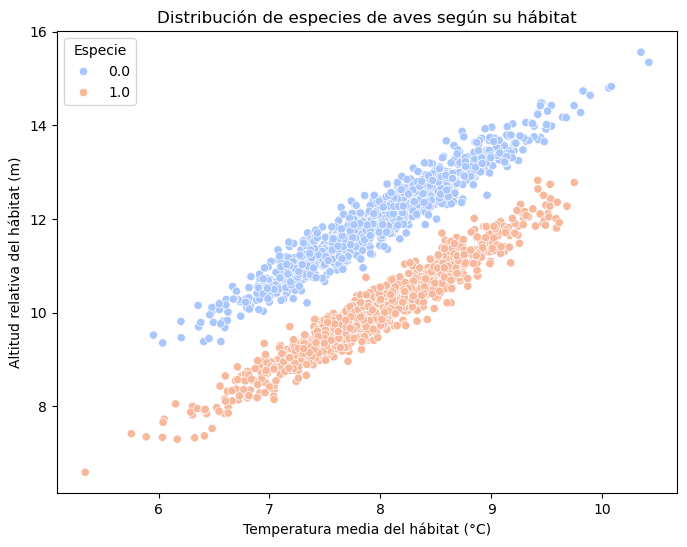

In [5]:
# Visualizar la distribución de las especies en el espacio de características
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, palette='coolwarm', alpha=1)
plt.xlabel("Temperatura media del hábitat (°C)")
plt.ylabel("Altitud relativa del hábitat (m)")
plt.title("Distribución de especies de aves según su hábitat")
plt.legend(title="Especie")
plt.show()

### Histogramas 

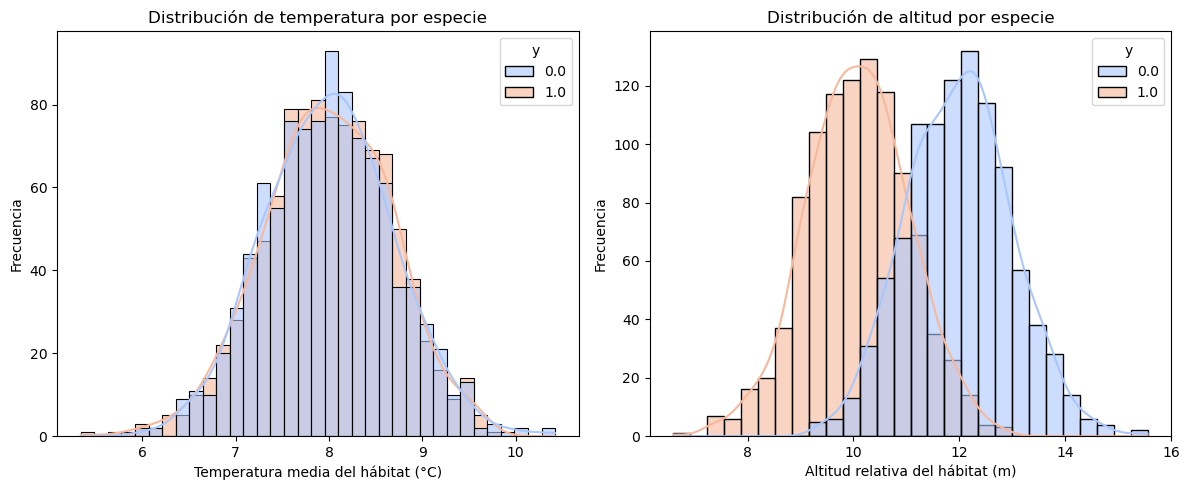

In [6]:
plt.figure(figsize=(12, 5))

# Histograma para la temperatura
plt.subplot(1, 2, 1)
sns.histplot(data, x="x1", hue="y", kde=True, palette="coolwarm", alpha=0.6)
plt.xlabel("Temperatura media del hábitat (°C)")
plt.ylabel("Frecuencia")
plt.title("Distribución de temperatura por especie")

# Histograma para la altitud
plt.subplot(1, 2, 2)
sns.histplot(data, x="x2", hue="y", kde=True, palette="coolwarm", alpha=0.6)
plt.xlabel("Altitud relativa del hábitat (m)")
plt.ylabel("Frecuencia")
plt.title("Distribución de altitud por especie")

plt.tight_layout()
plt.show()

## Función para cálculo de precisión

In [21]:
# Función para entrenar y evaluar un clasificador
def entrenar_y_evaluar(clasificador, X_ent, y_ent, X_val, y_val, X_test, y_test):
    # Entrenar el clasificador con los datos de entrenamiento
    clasificador.fit(X_ent, y_ent)
    
    # Predecir para los conjuntos de datos
    predicciones_ent = clasificador.predict(X_ent)
    predicciones_val = clasificador.predict(X_val)
    predicciones_test = clasificador.predict(X_test)
    
    # Calcular la precisión (accuracy)
    accuracy_ent = accuracy_score(y_ent, predicciones_ent) * 100
    accuracy_val = accuracy_score(y_val, predicciones_val) * 100
    accuracy_test = accuracy_score(y_test, predicciones_test) * 100
    
    # Imprimir los resultados
    print(f"Precisión en entrenamiento: {accuracy_ent:.3f}%")
    print(f"Precisión en validación: {accuracy_val:.3f}%")
    print(f"Precisión en prueba: {accuracy_test:.3f}%")

## División del conjunto de datos

In [19]:
# Separar características y etiquetas
X = data.iloc[:, :-1].to_numpy()
y = data.iloc[:, -1].to_numpy()

# Dividir en conjunto de entrenamiento (60%) y el resto (40%)
X_ent, X_temp, y_ent, y_temp = train_test_split(X, y, test_size=0.4, random_state=0)

# Dividir el conjunto temporal en validación (20%) y prueba (20%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=0)

# Ver las dimensiones de los conjuntos anteriores
print(f'Tamaño del conjunto de entrenamiento: {X_ent.shape}')
print(f'Tamaño del conjunto de validación: {X_val.shape}')
print(f'Tamaño del conjunto de prueba: {X_test.shape}')

Tamaño del conjunto de entrenamiento: (1200, 2)
Tamaño del conjunto de validación: (400, 2)
Tamaño del conjunto de prueba: (400, 2)


## Clasificadores Gaussianos

In [27]:
## Resultados con clasificador Gaussiano a manita
nb_gauss = NaiveBayesGaussiano()
print("Resultados con Naive Bayes Gaussiano a manita:")
entrenar_y_evaluar(nb_gauss, X_ent, y_ent, X_val, y_val, X_test, y_test)

## Resultados con Sklearn
nb_classifier = GaussianNB()
print("\nResultados con Naive Bayes Gaussiano de Sklearn:")
entrenar_y_evaluar(nb_classifier, X_ent, y_ent, X_val, y_val, X_test, y_test)

Resultados con Naive Bayes Gaussiano a manita:
Precisión en entrenamiento: 83.833%
Precisión en validación: 83.250%
Precisión en prueba: 83.500%

Resultados con Naive Bayes Gaussiano de Sklearn:
Precisión en entrenamiento: 83.833%
Precisión en validación: 83.250%
Precisión en prueba: 83.500%


# Elementos de Rendiemiento

## Frontera de decisión

In [32]:
# # Crear una malla de puntos en el espacio de características
# x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
# y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
# xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200), np.linspace(y_min, y_max, 200))

# # Predecir sobre la malla de puntos
# Z = nb_gauss.predict(np.c_[xx.ravel(), yy.ravel()])
# Z = Z.reshape(xx.shape)

# # Graficar la frontera de decisión
# plt.figure(figsize=(8, 6))
# plt.contourf(xx, yy, Z, alpha=0.3, cmap="coolwarm")
# sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, palette='coolwarm', edgecolor="k")
# plt.xlabel("Temperatura media del hábitat (°C)")
# plt.ylabel("Altitud relativa del hábitat (m)")
# plt.title("Frontera de decisión del clasificador Naive Bayes Gaussiano")
# plt.legend(title="Especie")
# plt.show()

## Matriz de confusión

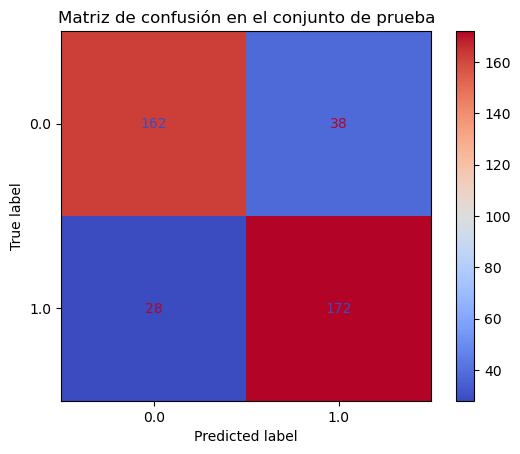

Precisión (Accuracy): 0.83
Precisión (Precision): 0.82
Recall: 0.86
F1-Score: 0.84


In [31]:
# Generar la matriz de confusión
cm = confusion_matrix(y_test, predicciones_test)

# Visualizar la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=nb_gauss.clases)
disp.plot(cmap="coolwarm")
plt.title("Matriz de confusión en el conjunto de prueba")
plt.show()

# Calcular las métricas
accuracy = accuracy_score(y_test, predicciones_test)
precision = precision_score(y_test, predicciones_test)
recall = recall_score(y_test, predicciones_test)
f1 = f1_score(y_test, predicciones_test)

# Imprimir las métricas
print(f"Precisión (Accuracy): {accuracy:.2f}")
print(f"Precisión (Precision): {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")

## ¿Qué es la Matriz de Confusión? 

La **matriz de confusión** es una herramienta que permite evaluar el desempeño de un clasificador. Para una clasificación binaria (dos clases), se presenta de la siguiente forma:

$$
\begin{bmatrix}
    \text{VP} & \text{FN} \\
    \text{FP} & \text{VN}
\end{bmatrix}
$$

Donde:

- **VP** (Verdaderos Positivos): Son los casos en los que el clasificador predice correctamente la clase positiva.
- **VN** (Verdaderos Negativos): Son los casos en los que el clasificador predice correctamente la clase negativa.
- **FP** (Falsos Positivos): Son los casos en los que el clasificador predice erróneamente la clase positiva cuando la clase real es negativa.
- **FN** (Falsos Negativos): Son los casos en los que el clasificador predice erróneamente la clase negativa cuando la clase real es positiva.

Para el caso con el que se está trabajando, si tenemos la siguiente matriz de confusión:

$$
\begin{bmatrix}
162 & 38 \\
28 & 172
\end{bmatrix}
$$

Esto significa que:
- 162 son los **verdaderos positivos** (el modelo predijo correctamente la clase positiva).
- 38 son los **falsos negativos** (el modelo predijo la clase negativa cuando la verdadera clase era positiva).
- 28 son los **falsos positivos** (el modelo predijo la clase positiva cuando la verdadera clase era negativa).
- 172 son los **verdaderos negativos** (el modelo predijo correctamente la clase negativa).


### Métricas de Desempeño


A partir de la matriz de confusión, se pueden calcular las siguientes métricas clave para evaluar el rendimiento del modelo:
 
1. Precisión (Accuracy)
La **precisión** es la proporción de predicciones correctas (tanto positivas como negativas) entre todas las predicciones realizadas:
    
    $$
    \text{Precisión} = \frac{\text{VP} + \text{VN}}{\text{VP} + \text{VN} + \text{FP} + \text{FN}}
    $$

2. Precisión Positiva (Precision)
La *precisión* positiva mide la exactitud de las predicciones positivas. Es decir, de todas las veces que el modelo predijo positivo, **¿cuántas veces fue realmente positivo?**

    $$
    \text{Precisión} = \frac{\text{VP}}{\text{VP} + \text{FP}}
    $$

3. Recall (Sensibilidad o Tasa de Verdaderos Positivos)
El *recall* mide la capacidad del modelo para identificar correctamente todas las instancias positivas. Es decir, de todas las veces que la clase real fue positiva, **¿cuántas veces el modelo la predijo correctamente?**

    $$
    \text{Recall} = \frac{\text{VP}}{\text{VP} + \text{FN}}
    $$

4. F1-Score
El *F1-score* es la media armónica entre la precisión y el recall. Es útil cuando las clases están desbalanceadas, ya que ofrece un solo valor para combinar precisión y recall en una sola métrica.

    $$
    F1 = 2 \times \frac{\text{Precisión} \times \text{Recall}}{\text{Precisión} + \text{Recall}}
    $$

Estas métricas ayudan a entender no solo qué tan preciso es el modelo en general, sino también cómo maneja las predicciones de las clases positivas y negativas.


### Para nuestros datos: 


Usando los valores de la matriz de confusión anterior:

- VP = 162
- FN = 38
- FP = 28
- VN = 172

Podemos calcular las métricas de la siguiente manera:

-*Accuracy* 
    $
    = \frac{162 + 172}{162 + 38 + 28 + 172} = \frac{334}{400} = 0.835
    $

-*Precisión Positiva*
    $
    = \frac{162}{162 + 28} = \frac{162}{190} \approx 0.853
    $

-*Recall*
    $
    = \frac{162}{162 + 38} = \frac{162}{200} = 0.81
    $

-*F1-Score*
    $
    = 2 \times \frac{0.853 \times 0.81}{0.853 + 0.81} \approx 0.831
    $

## Curva ROC

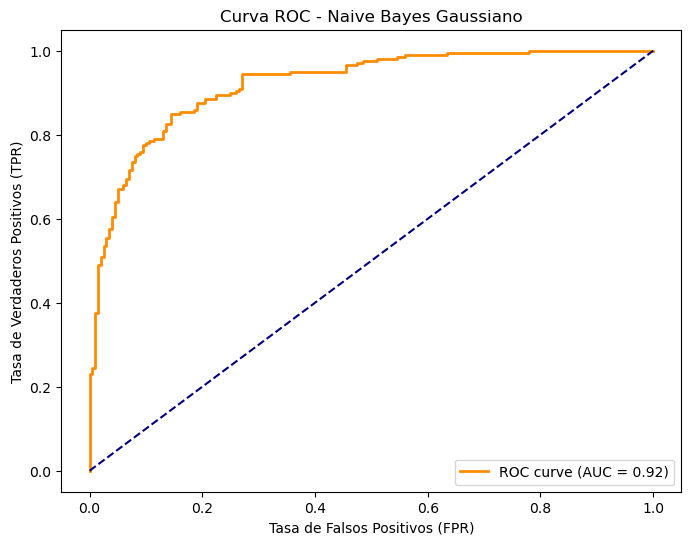

In [25]:
# Obtener probabilidades de la clase positiva (asumiendo que la segunda clase es la "positiva")
probabilidades = nb_gauss.calcular_probabilidades_posteriores(X_test)
prob_clase_1 = np.exp(probabilidades[:, 1]) / np.exp(probabilidades).sum(axis=1)  # Softmax para normalizar

# Convertir etiquetas a valores numéricos si es necesario
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_test_num = le.fit_transform(y_test)  # Convierte etiquetas de clase a 0 y 1

# Calcular la curva ROC
fpr, tpr, _ = roc_curve(y_test_num, prob_clase_1)
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")  # Línea de referencia
plt.xlabel("Tasa de Falsos Positivos (FPR)")
plt.ylabel("Tasa de Verdaderos Positivos (TPR)")
plt.title("Curva ROC - Naive Bayes Gaussiano")
plt.legend(loc="lower right")
plt.show()

## ¿Qué es la Curva ROC?

La **Curva ROC (Receiver Operating Characteristic)** es una herramienta que evalúa el desempeño de un modelo de clasificación binaria.

Se construye variando el umbral de decisión y observando dos métricas:

1. **Tasa de Verdaderos Positivos (TPR - Sensibilidad)**
   $$ TPR = \frac{VP}{VP + FN} $$
   Mide la proporción de ejemplos positivos correctamente identificados.

2. **Tasa de Falsos Positivos (FPR)**
   $$ FPR = \frac{FP}{FP + VN} $$
   Mide la proporción de ejemplos negativos que fueron clasificados erróneamente como positivos.


### Interpretación de la Curva ROC

- El eje **X** representa la **Tasa de Falsos Positivos (FPR)**.
- El eje **Y** representa la **Tasa de Verdaderos Positivos (TPR)**.
- La **línea diagonal** \( y = x \) representa un clasificador aleatorio.
- Cuanto más se acerque la curva a la **esquina superior izquierda (0,1)**, mejor será el modelo.


### Área Bajo la Curva (AUC)

El **AUC (Area Under the Curve)** mide el rendimiento general del modelo:

- **AUC ≈ 1** → El modelo clasifica perfectamente.
- **AUC ≈ 0.5** → El modelo es aleatorio.
- **AUC < 0.5** → El modelo es peor que un clasificador aleatorio.

## Desempeño

In [36]:
# Analizar el desempeño
print("\nAnálisis del desempeño:")
print("-" * 100)
print(f"La precisión en entrenamiento es {accuracy_ent_gaussiano:.2f}%, lo que indica qué tan bien el modelo ha aprendido los patrones en los datos de entrenamiento.")
print(f"La precisión en validación es {accuracy_val_gaussiano:.2f}%, utilizada para medir la capacidad del modelo de generalizar antes de probarlo con datos nuevos.")
print(f"La precisión en prueba es {accuracy_test_gaussiano:.2f}%, reflejando el rendimiento final del modelo en datos nunca antes vistos.")
print("-" * 100)

# Evaluar si hay sobreajuste o subajuste
gap_train_val = accuracy_ent_gaussiano - accuracy_val_gaussiano

if gap_train_val > 10:
    print("\n Posible sobreajuste: El modelo tiene un desempeño mucho mejor en entrenamiento que en validación/prueba. Puede estar aprendiendo patrones específicos en lugar de generalizar bien.")
elif accuracy_ent_gaussiano < 70 and accuracy_val_gaussiano < 70:
    print("\n Posible subajuste: El modelo tiene un desempeño bajo en todos los conjuntos, lo que indica que no está aprendiendo bien los patrones.")
else:
    print("\n El modelo parece tener un buen equilibrio entre ajuste y generalización.")



Análisis del desempeño:
----------------------------------------------------------------------------------------------------
La precisión en entrenamiento es 83.83%, lo que indica qué tan bien el modelo ha aprendido los patrones en los datos de entrenamiento.
La precisión en validación es 83.25%, utilizada para medir la capacidad del modelo de generalizar antes de probarlo con datos nuevos.
La precisión en prueba es 83.50%, reflejando el rendimiento final del modelo en datos nunca antes vistos.
----------------------------------------------------------------------------------------------------

 El modelo parece tener un buen equilibrio entre ajuste y generalización.


# **CONCLUSIÓN**:

El modelo presenta un desempeño bastante bueno. Si bien no es perfecto, sus métricas indican que *clasifica correctamente la mayoría de los ejemplos y mantiene un buen equilibrio entre ajuste y generalización*.

#### Métricas Clave:
- **Precisión global**: $83\%$ → Indica que el modelo clasifica correctamente la mayoría de los casos.
- **Precisión (positiva)**: $82\%$ → Cuando predice la clase positiva, **acierta en la mayoría de los casos**.
- **Recall**: $86\%$ → **Detecta correctamente la mayoría de los casos positivos**, con pocos falsos negativos.
- **F1-score**: $84\%$ → Refleja un **buen equilibrio entre precisión y recall**, evitando sesgos.

#### Curva ROC:
El **AUC-ROC** obtenido es **0.92**, lo que significa que el modelo **tiene una excelente capacidad para distinguir entre clases**.

En general, aunque no es un modelo perfecto, **su desempeño es bastante bueno para la tarea planteada**. 